#Fashion MNIST classification with CNN

# Dataset load 

torchvision과 transforms를 이용한 dataset 구축

torchvision.datasets.FashionMNIST()를 이용하여 array형태의 학습데이터셋을 반환하는 torch.utils.data.Dataset클래스 load  
torchvision.transforms를 이용하여 해당 데이터를 Tensor로 변환하고 Normalize하여 값을 스케일링 한다.

다음 doc참조:  
FashionMNIST:https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html  
transforms: https://pytorch.org/vision/stable/transforms.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#load할 dataset에 사전작업될 이미지 전처리
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5,0.5)])

#torchvision을 통한 dataset load
trainDataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
testDataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

for i in trainDataset:
  print(i[0])
  print(i[0].shape)
  print(i[1])
  break

#batch processing을 위한 dataloader 구성
batch_size = 20
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=batch_size,shuffle=False)

for i in trainDataloader:
  print(i[0])
  print(i[0].shape)
  print(i[1])
  print(i[1].shape)
  break

print(len(trainDataset))
print(len(testDataset))


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0

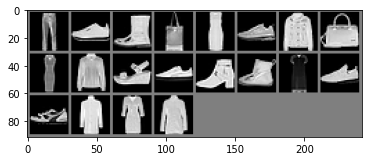

tensor(1) tensor(7) tensor(9) tensor(8) tensor(3) tensor(7) tensor(4) tensor(8) tensor(3) tensor(6) tensor(5) tensor(7) tensor(9) tensor(9) tensor(3) tensor(7) tensor(7) tensor(4) tensor(3) tensor(4)


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainDataloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

Model 선언
nn.Module를 통해 모델의 구조결정

CNN 기반의 모델을 선언한다.  
모델의 구조는  
**2D CNN** with kernelsize=5,5 out_channel = 6, activation=ReLU    
**maxpooling** kernelsize=2,2 stride=2    
**2D CNN** with kernelsize=5,5 out_channel = 16, stride = 2, activation=ReLU  
**1st layer MLP** out_feature = 120, activation=ReLU  
**output layer MLP** out_feature = num_class  


각 오브젝트의 입력과 선언은 다음 doc 참조:  
Conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html  
MaxPool2d: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html  
Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [3]:
import torch.nn as nn


class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        #print(x.shape)
        x = self.relu(self.conv1(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.relu(self.conv2(x))
        #print(x.shape)
        x = x.reshape(-1, 16 * 4 * 4)
        #print(x.shape)
        x = self.relu(self.fc1(x))
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return x


model = myModel().cuda()

for i in trainDataloader:
  data = i[0].cuda()
  target = i[1].cuda()

  print(model(data).shape)
  break

torch.Size([20, 10])


작성한 dataset과 model을 이용하여 딥러닝 프로세스 구현  

pytorch 딥러닝 프로세스
1. dataset, model선언
2. dataset과 model을 통한 결과 예측
3. 예측된 결과를 통해 **loss**연산 및 **loss.backward**
4. **optimizer.step()**를 사용하여 graident update

주요 오브젝트  
torch.nn.CrossEntropyLoss: 문장 분류를 위한 loss 수행  
torch.optim.Adam: Adam optimizer를 통해 gradient update를 수행하는 class

각 오브젝트의 입력과 선언은 다음 doc 참조:  
CrossEntropyLoss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html  
Adam: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

#학습을 위한 optimizer와 loss function 설정
optimizer = Adam(model.parameters(), lr=0.001)
lf = CrossEntropyLoss().cuda()
#model.cuda()

#100번의 에폭을 실행
for e in range(100):
  print("\n\nepoch ", e)
  epoch_loss = 0
  train_correct = 0 
  
  #선언한 모델 오브젝트를 학습가능한 상태로 변경
  model.train()

  #모든 학습데이터에 대해서 학습
  for i in trainDataloader:
    #매 배치에 대한 gradient계산 이전에 optimizer에 저장된 이전 batch에 gradient를 삭제(초기화)
    optimizer.zero_grad()
    data = i[0]
    data = data.cuda()
    target = i[1]
    target = target.cuda()

    #결과 도출 및 정답수 연산
    output = model(data)
    pred_label = torch.argmax(output, dim=-1)
    train_correct += sum(pred_label == target.reshape(-1))

    target = target.reshape(-1)
    #loss연산
    loss = lf(output, target)
    #print(loss)

    #loss backpropagation
    loss.backward()

    #gradient update
    optimizer.step()

    epoch_loss += loss.item()
  
  print("train loss", epoch_loss/len(trainDataloader))
  print("train acc", train_correct/len(trainDataset))

  #model이 학습되지 않는 상태로 변경
  model.eval()
  test_loss = 0
  test_correct = 0 

  #gradient를 계산하지 않도록 하여 cost낭비 방지
  with torch.no_grad():
    #모든 test dataset에 대해서 결과연산
    for i in testDataloader:
      data = i[0]
      target = i[1]
      data = data.cuda()
      target = target.cuda()

      output = model(data)

      loss = lf(output, target.reshape(-1))
      pred_label = torch.argmax(output, dim=-1)
      test_correct += sum(pred_label == target.reshape(-1))
      test_loss += loss.item()

  print("test loss", test_loss/len(testDataloader))
  print("test acc", test_correct/len(testDataset))
    




epoch  0
train loss 0.5040237545905014
train acc tensor(0.8124, device='cuda:0')
test loss 0.39510821729153395
test acc tensor(0.8567, device='cuda:0')


epoch  1
train loss 0.3527924460824579
train acc tensor(0.8706, device='cuda:0')
test loss 0.3484456487149
test acc tensor(0.8754, device='cuda:0')


epoch  2
train loss 0.3115848417831585
train acc tensor(0.8852, device='cuda:0')
test loss 0.3199517778418958
test acc tensor(0.8839, device='cuda:0')


epoch  3
train loss 0.2828615317825849
train acc tensor(0.8948, device='cuda:0')
test loss 0.3087202182430774
test acc tensor(0.8913, device='cuda:0')


epoch  4
train loss 0.26343228917537875
train acc tensor(0.9022, device='cuda:0')
test loss 0.29853103662561625
test acc tensor(0.8926, device='cuda:0')


epoch  5
train loss 0.24872917667403818
train acc tensor(0.9074, device='cuda:0')
test loss 0.2925018813954666
test acc tensor(0.8946, device='cuda:0')


epoch  6
train loss 0.23287019291101024
train acc tensor(0.9137, device='cuda:0